In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix as CM, precision_score as P, recall_score as R

## 样本不均衡

In [120]:
# 创建两个不平衡的数据样本
class_1 = 500
class_2 = 50
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, .5]
X, y = make_blobs(n_samples=[class_1, class_2]
                  , centers=centers
                  , cluster_std=clusters_std
                  , shuffle = True
                  , random_state = 0)
X.shape

(550, 2)

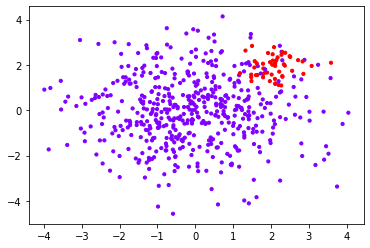

In [121]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow", s=10)
plt.show()

In [122]:
# 建模
clf = SVC(kernel="linear", C = 1.0)
clf.fit(X, y)
clf.score(X,y)

0.9418181818181818

In [123]:
wclf = SVC(kernel="linear", class_weight={1:10})
wclf.fit(X, y)
wclf.score(X,y)

0.9127272727272727

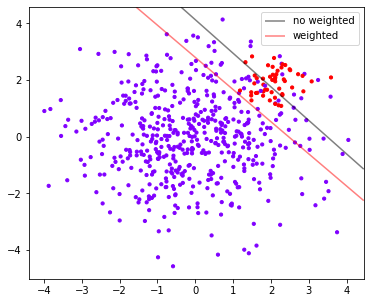

In [124]:
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow", s=10)
ax = plt.gca()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
XX, YY = np.meshgrid(xx, yy)
ZZ = np.vstack([XX.ravel(), YY.ravel()]).T

P0 = clf.decision_function(ZZ).reshape(XX.shape)
# 绘制等高线
a = ax.contour(XX, YY, P0, colors = "black", levels = [0], alpha = 0.5, linestyles =['-'])


P1 = wclf.decision_function(ZZ).reshape(XX.shape)
# 绘制等高线
b = ax.contour(XX, YY, P1, colors = "red", levels = [0], alpha = 0.5, linestyles =['-'])
plt.legend([a.collections[0], b.collections[0]], ["no weighted", "weighted"], loc="upper right")
plt.show()

结论：模型在样本不平衡时向着样本多数类的方向建模

## 模型评估指标

### 精确度

In [125]:
X.shape

(550, 2)

In [126]:
### 精确度
(y[y == clf.predict(X)] == 1).sum()/(clf.predict(X)==1).sum()

0.7142857142857143

In [127]:
(y[y == wclf.predict(X)] == 1).sum()/(wclf.predict(X)==1).sum()

0.5102040816326531

### 召回率(查全率,查正率)

In [128]:
(y[y == clf.predict(X)] == 1).sum()/(y==1).sum()

0.6

In [129]:
(y[y == wclf.predict(X)] == 1).sum()/(y==1).sum()

1.0

## ROC曲线

In [130]:
clf_proba = SVC(kernel="linear", C=1.0, probability=True).fit(X, y)

In [131]:
# 返回样本点属于哪一个类别的概率
clf_proba.predict_proba(X)

array([[9.65591445e-01, 3.44085545e-02],
       [9.95805321e-01, 4.19467933e-03],
       [9.99711800e-01, 2.88199987e-04],
       ...,
       [9.99166353e-01, 8.33646820e-04],
       [9.99913942e-01, 8.60575224e-05],
       [9.86908275e-01, 1.30917253e-02]])

In [132]:
clf_proba.predict_proba(X).shape

(550, 2)

In [133]:
clf_proba.decision_function(X).shape

(550,)

In [134]:
from sklearn.linear_model import LogisticRegression as LR
clf_lo = LR().fit(X, y)
prob = clf_lo.predict_proba(X)

In [135]:
import pandas as pd 

In [136]:
prob = pd.DataFrame(prob)
prob.columns = ["0", "1"]

In [137]:
## 手动调节阀值
for i in range(prob.shape[0]):
    if prob.loc[i, "1"] >0.5:
        prob.loc[i, "pred"] = 1
    else:
        prob.loc[i, "pred"] = 0

In [138]:
prob["y_true"] = y

In [139]:
prob.head()

,0,1,pred,y_true
0,0.969736,0.030264,0.0,0
1,0.996543,0.003457,0.0,0
2,0.999817,0.000183,0.0,0
3,0.994903,0.005097,0.0,0
4,0.999918,0.000082,0.0,0


In [140]:
prob = prob.sort_values(by="1", ascending=False)

In [141]:
prob.tail()

,0,1,pred,y_true
89,0.999999,1.330771e-06,0.0,0
231,0.999999,1.312355e-06,0.0,0
336,0.999999,1.116952e-06,0.0,0
480,0.999999,1.017827e-06,0.0,0
208,1.000000,3.408812e-07,0.0,0


In [142]:
CM(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

array([[ 26,  24],
       [ 12, 488]])

In [143]:
R(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

0.52

In [144]:
P(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

0.6842105263157895

In [145]:
## 手动调节阀值
for i in range(prob.shape[0]):
    if prob.loc[i, "1"] >0.4:
        prob.loc[i, "pred"] = 1
    else:
        prob.loc[i, "pred"] = 0

In [146]:
CM(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

array([[ 33,  17],
       [ 15, 485]])

In [147]:
R(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

0.66

In [148]:
P(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

0.6875

### 绘制Recall

In [149]:
cm = CM(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])
cm

array([[ 33,  17],
       [ 15, 485]])

In [150]:
## 负假率FPR
cm[1, 0]/cm[1, :].sum()

0.03

In [151]:
## Recall
cm[0, 0] / cm[0, :].sum()

0.66

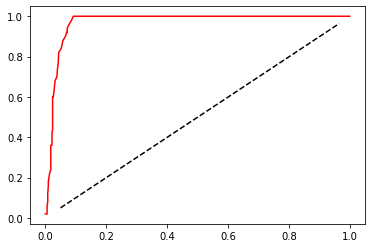

In [155]:
## 绘制ROC曲线
recall = []
FPR = []

# 不同的阈值
probrange = np.linspace(clf_proba.predict_proba(X)[:, 1].min()
                        , clf_proba.predict_proba(X)[:, 1].max()
                        , endpoint=False
                        , num = 50)
for i in probrange:
    y_predicted = []
    for j in range(X.shape[0]):
        # 计算不同阈值下的分类效果
        if clf_proba.predict_proba(X)[j, 1] > i:
            y_predicted.append(1)
        else:
            y_predicted.append(0)
    cm = CM(y, y_predicted, labels=[1, 0])
    recall.append(cm[0, 0]/cm[0, :].sum())
    FPR.append(cm[1, 0]/ cm[1, :].sum())
        
recall.sort()
FPR.sort()

plt.plot(FPR, recall, c="red")
plt.plot(probrange + 0.05, probrange + 0.05, c="black", linestyle = "--")
plt.show()

说明:横坐标
是FPR，代表着模型将多数类判断错误的能力，纵坐标Recall，代表着模型捕捉少数类的能力，所以ROC曲线代表
着，随着Recall的不断增加，FPR如何增加。**我们希望随着Recall的不断提升，FPR增加得越慢越好**，***这说明我们可
以尽量高效地捕捉出少数类，而不会将很多地多数类判断错误。***所以，我们希望看到的图像是，纵坐标急速上升，
横坐标缓慢增长，也就是在整个图像左上方的一条弧线。这代表模型的效果很不错，拥有较好的捕获少数类的能
力

In [153]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as AUC

In [109]:
FPR, recall, thresholds = roc_curve(y, clf_proba.decision_function(X), pos_label=1)
FPR

array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [110]:
recall

array([0.  , 0.02, 0.02, 0.06, 0.06, 0.16, 0.16, 0.2 , 0.2 , 0.22, 0.22,
       0.36, 0.36, 0.42, 0.42, 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.68,
       0.68, 0.7 , 0.7 , 0.74, 0.74, 0.76, 0.76, 0.82, 0.82, 0.84, 0.84,
       0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  ,
       1.  ])

In [111]:
thresholds

array([  3.18309238,   2.18309238,   1.487292  ,   1.36013561,
         1.33969459,   1.14080874,   1.13425759,   1.00042184,
         0.85120067,   0.84510701,   0.78603908,   0.60595402,
         0.53916007,   0.46741802,   0.44418651,   0.03917867,
        -0.07003614,  -0.10662136,  -0.12576085,  -0.13840026,
        -0.1402857 ,  -0.16785837,  -0.20405822,  -0.22134427,
        -0.2437886 ,  -0.2676054 ,  -0.34447107,  -0.34680142,
        -0.39183942,  -0.40678594,  -0.45894292,  -0.46314073,
        -0.49200321,  -0.50894516,  -0.53566444,  -0.55158427,
        -0.62637385,  -0.67590378,  -0.78140225,  -0.79887977,
        -0.8845502 ,  -0.91274643,  -1.01437407,  -1.08623807,
       -10.32250029])

In [101]:
area = AUC(y, clf_proba.decision_function(X))
area

0.9696400000000001

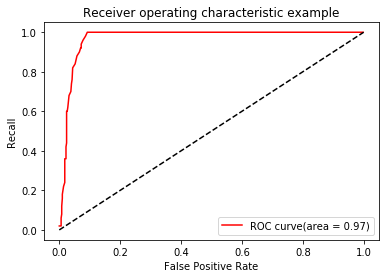

In [157]:
plt.figure()
plt.plot(FPR, recall, color="red",
         label = "ROC curve(area = %0.2f)" % area)
plt.plot([0, 1], [0, 1], c="black", linestyle = "--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [158]:
# 找寻最佳阀值的点
maxindex = (recall - FPR).tolist().index(max(recall -FPR))

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [159]:
thresholds[maxindex]

-1.0862380731808159

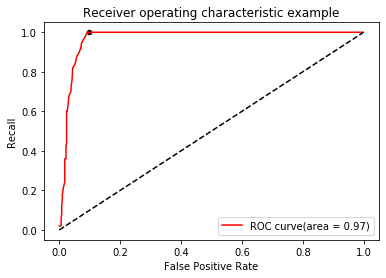

In [160]:
plt.figure()
plt.plot(FPR, recall, color="red",
         label = "ROC curve(area = %0.2f)" % area)
plt.plot([0, 1], [0, 1], c="black", linestyle = "--")
plt.scatter(FPR[maxindex], recall[maxindex], c="black", s=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 重要的属性接口

In [161]:
clf_proba.n_support_

array([42, 41], dtype=int32)

In [162]:
clf_proba.coef_

array([[1.16998682, 0.98750216]])

In [163]:
clf_proba.intercept_

array([-4.08045056])

In [164]:
clf_proba.dual_coef_

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.50335167,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -0.2502634 , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1. 

In [165]:
clf_proba.dual_coef_.shape

(1, 83)

In [166]:
clf_proba.support_

array([  6,   8,  12,  16,  28,  35,  41,  42,  50,  53,  64,  69,  87,
        91,  99, 107, 126, 128, 177, 184, 190, 225, 229, 256, 258, 304,
       322, 334, 379, 390, 404, 408, 423, 439, 450, 467, 490, 493, 498,
       505, 533, 546,  21,  49,  59,  63,  77,  83,  94, 100, 103, 129,
       131, 135, 144, 155, 159, 174, 223, 276, 296, 301, 319, 366, 368,
       371, 372, 373, 406, 409, 438, 448, 457, 460, 471, 489, 510, 518,
       519, 521, 527, 532, 542], dtype=int32)

In [168]:
clf_proba.support_vectors_.shape

(83, 2)